## Import Libraries and Configure Logging



In [104]:
import cv2
from pathlib import Path
import albumentations as A
from tqdm import tqdm
from collections import defaultdict
import logging
import numpy as np
import matplotlib.pyplot as plt
import random

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


## Define Paths

In [105]:
# Define paths
preprocessed_images_dir = Path('../preprocessed_dataset/images')
preprocessed_labels_dir = Path('../preprocessed_dataset/labels')
augmented_images_dir = Path('../augmented_dataset/images')
augmented_labels_dir = Path('../augmented_dataset/labels')

# Create output directories
augmented_images_dir.mkdir(parents=True, exist_ok=True)
augmented_labels_dir.mkdir(parents=True, exist_ok=True)


## Define Augmentation Pipeline

In [106]:
# Enhanced augmentation pipeline with CoarseDropout
augmentation_pipeline = A.Compose([
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomScale(scale_limit=0.1, p=0.5),  # ±10% scaling
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),  # Color jittering
    A.CoarseDropout(max_holes=8, max_height=0.05, max_width=0.05, p=0.3),  # Occlusion simulation
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'], min_visibility=0.3))

# Class names
class_names = {0: 'door', 1: 'table', 2: 'openedDoor', 3: 'chair', 4: 'pole', 
               5: 'bike', 6: 'truck', 7: 'car', 8: 'dog', 9: 'bus'}

# Count annotations in preprocessed dataset
annotation_counts = defaultdict(int)
for label_file in preprocessed_labels_dir.glob('*.txt'):
    with open(label_file, 'r') as f:
        lines = f.readlines()
    for line in lines:
        parts = line.strip().split()
        if len(parts) >= 5:
            try:
                class_id = int(parts[0])
                annotation_counts[class_id] += 1
            except ValueError:
                logger.warning(f"Invalid class ID in {label_file}: {parts[0]}")

# Log initial counts
for class_id, count in annotation_counts.items():
    logger.info(f"{class_names[class_id]}: {count} annotations")

# Define augmentation factors
def get_augmentation_factor(count):
    if count < 1000:
        return 20
    elif count < 5000:
        return 10
    elif count < 10000:
        return 5
    else:
        return 0

logger.info("Augmentation factors defined.")

/tmp/ipykernel_24753/1867994116.py:8: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=0.05, max_width=0.05, p=0.3),  # Occlusion simulation
2025-03-25 03:10:24,874 - INFO - truck: 3537 annotations
2025-03-25 03:10:24,874 - INFO - pole: 31188 annotations
2025-03-25 03:10:24,875 - INFO - dog: 1022 annotations
2025-03-25 03:10:24,875 - INFO - car: 27583 annotations
2025-03-25 03:10:24,876 - INFO - bike: 18157 annotations
2025-03-25 03:10:24,876 - INFO - bus: 1787 annotations
2025-03-25 03:10:24,877 - INFO - openedDoor: 111 annotations
2025-03-25 03:10:24,877 - INFO - chair: 340 annotations
2025-03-25 03:10:24,877 - INFO - door: 603 annotations
2025-03-25 03:10:24,878 - INFO - table: 315 annotations
2025-03-25 03:10:24,878 - INFO - Augmentation factors defined.


## Filter and Augment Images



Filter images containing underrepresented classes and apply augmentation.

In [107]:
# Get label files
label_files = list(preprocessed_labels_dir.glob('*.txt'))

total_images_processed = 0
total_augmented_images = 0
total_boxes_removed = 0

def validate_and_clip_bbox(bbox, class_id, label_file):
    x_center, y_center, width, height = bbox
    x_center = max(0.0, min(1.0, x_center))
    y_center = max(0.0, min(1.0, y_center))
    width = max(0.0, min(1.0, width))
    height = max(0.0, min(1.0, height))
    x_min = x_center - width / 2
    x_max = x_center + width / 2
    y_min = y_center - height / 2
    y_max = y_center + height / 2
    if x_min >= x_max or y_min >= y_max:
        logger.debug(f"Invalid bbox clipped out in {label_file}: {bbox}, class {class_id}")
        return None
    return [x_center, y_center, width, height]

for label_file in tqdm(label_files, desc="Augmenting dataset"):
    image_file = preprocessed_images_dir / (label_file.stem + '.jpg')
    if not image_file.exists():
        logger.warning(f"Image not found: {image_file}")
        continue
    img = cv2.imread(str(image_file))
    if img is None:
        logger.warning(f"Failed to load image: {image_file}")
        continue
    
    # Parse and validate YOLO labels
    with open(label_file, 'r') as f:
        lines = f.readlines()
    bboxes = []
    class_labels = []
    for line in lines:
        parts = line.strip().split()
        if len(parts) < 5:
            logger.warning(f"Skipping invalid line in {label_file}: {line.strip()}")
            continue
        try:
            class_id = int(parts[0])
            bbox = list(map(float, parts[1:5]))
            if len(bbox) == 4:
                valid_bbox = validate_and_clip_bbox(bbox, class_id, label_file)
                if valid_bbox:
                    bboxes.append(valid_bbox)
                    class_labels.append(class_id)
                else:
                    total_boxes_removed += 1
        except ValueError:
            logger.warning(f"Invalid data in {label_file}: {parts}")
            continue
    
    # Identify rare classes in this image
    rare_classes = {cls for cls in class_labels if annotation_counts.get(cls, 0) < 1000}
    augmentation_factor = 0
    if rare_classes:
        augmentation_factor = max(get_augmentation_factor(annotation_counts[cls]) for cls in rare_classes)
    
    # Generate augmented versions
    if augmentation_factor > 0:
        for i in range(augmentation_factor):
            try:
                augmented = augmentation_pipeline(image=img, bboxes=bboxes, class_labels=class_labels)
                augmented_img = augmented['image']
                augmented_bboxes = augmented['bboxes']
                augmented_class_labels = augmented['class_labels']
                
                # Process all valid bboxes
                valid_bboxes = []
                valid_class_labels = []
                for bbox, cls in zip(augmented_bboxes, augmented_class_labels):
                    x_center, y_center, width, height = bbox
                    x_min = x_center - width / 2
                    x_max = x_center + width / 2
                    y_min = y_center - height / 2
                    y_max = y_center + height / 2
                    x_min = max(x_min, 0.0)
                    x_max = min(x_max, 1.0)
                    y_min = max(y_min, 0.0)
                    y_max = min(y_max, 1.0)
                    if x_min < x_max and y_min < y_max:
                        new_x_center = (x_min + x_max) / 2
                        new_width = x_max - x_min
                        new_y_center = (y_min + y_max) / 2
                        new_height = y_max - y_min
                        valid_bboxes.append([new_x_center, new_y_center, new_width, new_height])
                        valid_class_labels.append(cls)
                    else:
                        total_boxes_removed += 1
                        logger.debug(f"Removed invalid bbox: {bbox}, class {cls}")
                
                if valid_bboxes:
                    aug_image_path = augmented_images_dir / f"{label_file.stem}_aug_{i}.jpg"
                    aug_label_path = augmented_labels_dir / f"{label_file.stem}_aug_{i}.txt"
                    cv2.imwrite(str(aug_image_path), augmented_img)
                    with open(aug_label_path, 'w') as f:
                        for cls, bbox in zip(valid_class_labels, valid_bboxes):
                            f.write(f"{cls} {' '.join(map(str, bbox))}\n")
                    total_augmented_images += 1
            except Exception as e:
                logger.warning(f"Augmentation failed for {image_file}: {e}")
                continue
    
    # Save original image and label
    orig_aug_image_path = augmented_images_dir / image_file.name
    orig_aug_label_path = augmented_labels_dir / label_file.name
    cv2.imwrite(str(orig_aug_image_path), img)
    with open(orig_aug_label_path, 'w') as f:
        f.writelines(lines)
    
    total_images_processed += 1

logger.info(f"Augmentation completed.")
logger.info(f"Total images in augmented dataset: {total_images_processed + total_augmented_images}")
logger.info(f"Total augmented images generated: {total_augmented_images}")
logger.info(f"Total bounding boxes removed due to invalidation: {total_boxes_removed}")

Augmenting dataset:  39%|███▉      | 9592/24402 [00:37<01:26, 171.38it/s]2025-03-25 03:12:03,765 - WARNING - Augmentation failed for ../preprocessed_dataset/images/n_908.jpg: Expected x_min for bbox [-5.0663948e-07  4.9432352e-01  2.6935449e-01  8.7013054e-01
  1.0000000e+00] to be in the range [0.0, 1.0], got -5.066394805908203e-07.
2025-03-25 03:12:03,766 - WARNING - Augmentation failed for ../preprocessed_dataset/images/n_908.jpg: Expected x_min for bbox [-5.0663948e-07  4.9432352e-01  2.6935449e-01  8.7013054e-01
  1.0000000e+00] to be in the range [0.0, 1.0], got -5.066394805908203e-07.
2025-03-25 03:12:03,767 - WARNING - Augmentation failed for ../preprocessed_dataset/images/n_908.jpg: Expected x_min for bbox [-5.0663948e-07  4.9432352e-01  2.6935449e-01  8.7013054e-01
  1.0000000e+00] to be in the range [0.0, 1.0], got -5.066394805908203e-07.
2025-03-25 03:12:03,768 - WARNING - Augmentation failed for ../preprocessed_dataset/images/n_908.jpg: Expected x_min for bbox [-5.0663948e

## Visualize Results



Visualize an original and its augmented version to confirm the process.



In [108]:
# Verify annotation counts
augmented_counts = defaultdict(int)
for label_file in augmented_labels_dir.glob('*.txt'):
    with open(label_file, 'r') as f:
        lines = f.readlines()
    for line in lines:
        parts = line.strip().split()
        if len(parts) < 5:
            logger.warning(f"Skipping invalid line in {label_file}: {line.strip()}")
            continue
        try:
            class_id = int(float(parts[0]))
            augmented_counts[class_id] += 1
        except ValueError:
            logger.warning(f"Invalid class ID in {label_file}: {parts[0]}")

# Log augmented counts
for class_id, count in augmented_counts.items():
    logger.info(f"{class_names[class_id]} in augmented dataset: {count} annotations")

2025-03-25 03:13:43,379 - INFO - truck in augmented dataset: 3537 annotations
2025-03-25 03:13:43,379 - INFO - pole in augmented dataset: 31868 annotations
2025-03-25 03:13:43,379 - INFO - table in augmented dataset: 6567 annotations
2025-03-25 03:13:43,380 - INFO - openedDoor in augmented dataset: 2310 annotations
2025-03-25 03:13:43,380 - INFO - door in augmented dataset: 12611 annotations
2025-03-25 03:13:43,381 - INFO - dog in augmented dataset: 1022 annotations
2025-03-25 03:13:43,381 - INFO - car in augmented dataset: 27583 annotations
2025-03-25 03:13:43,381 - INFO - bike in augmented dataset: 18157 annotations
2025-03-25 03:13:43,382 - INFO - chair in augmented dataset: 7085 annotations
2025-03-25 03:13:43,384 - INFO - bus in augmented dataset: 1787 annotations


## Verify Dataset



Ensure all images have corresponding labels and vice versa.



In [109]:
def verify_dataset():
    image_files = set(f.stem for f in augmented_images_dir.glob('*.jpg'))
    label_files = set(f.stem for f in augmented_labels_dir.glob('*.txt'))
    
    missing_labels = image_files - label_files
    missing_images = label_files - image_files
    
    if missing_labels:
        logger.warning(f"Images missing labels: {len(missing_labels)} - {list(missing_labels)[:5]}")
    if missing_images:
        logger.warning(f"Labels missing images: {len(missing_images)} - {list(missing_images)[:5]}")
    else:
        logger.info("Dataset verified: All images have corresponding labels and vice versa.")
    
    logger.info(f"Total images in augmented dataset: {len(image_files)}")
    logger.info(f"Total labels in augmented dataset: {len(label_files)}")

verify_dataset()

2025-03-25 03:15:38,905 - INFO - Dataset verified: All images have corresponding labels and vice versa.
2025-03-25 03:15:38,905 - INFO - Total images in augmented dataset: 37116
2025-03-25 03:15:38,905 - INFO - Total labels in augmented dataset: 37116


## Visualize Annotation Distribution (Bar Plot)



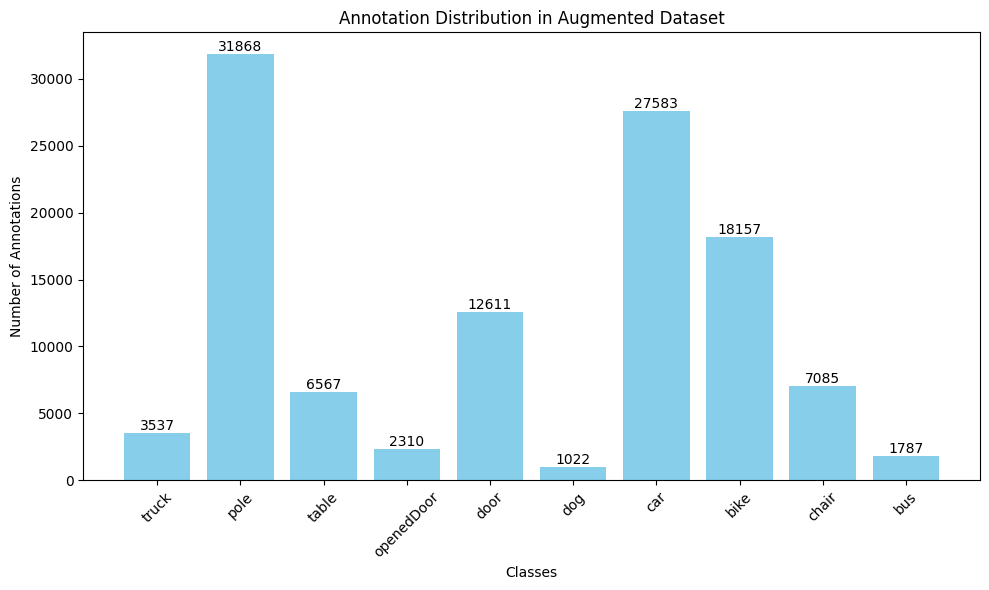

In [110]:
# Bar plot
class_ids = list(augmented_counts.keys())
counts = list(augmented_counts.values())
class_labels = [class_names.get(cid, f"Class {cid}") for cid in class_ids]
plt.figure(figsize=(10, 6))
bars = plt.bar(class_labels, counts, color='skyblue')
plt.bar_label(bars, labels=counts)
plt.xlabel('Classes')
plt.ylabel('Number of Annotations')
plt.title('Annotation Distribution in Augmented Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Visualize Random Images with Bounding Boxes



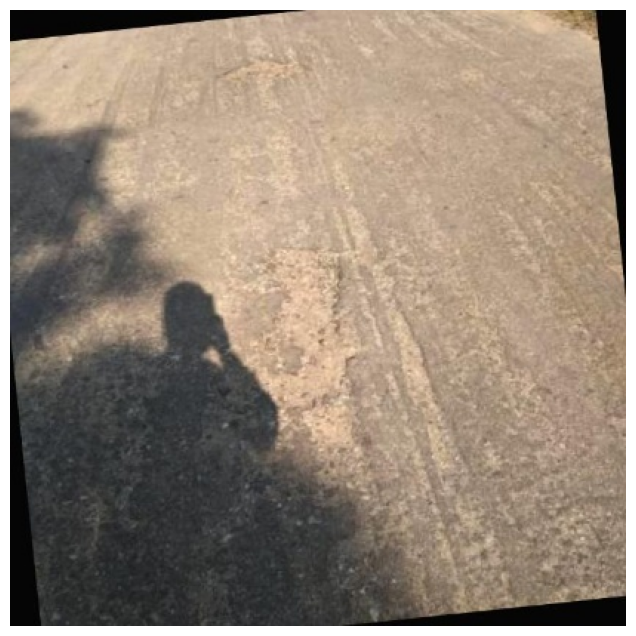

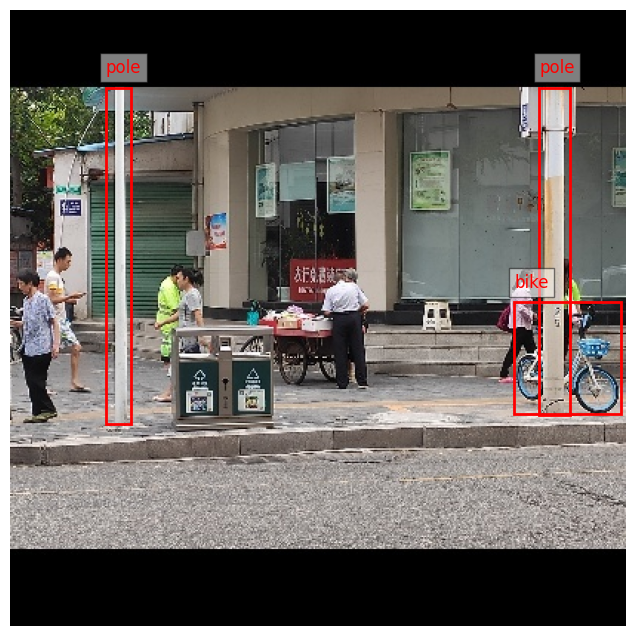

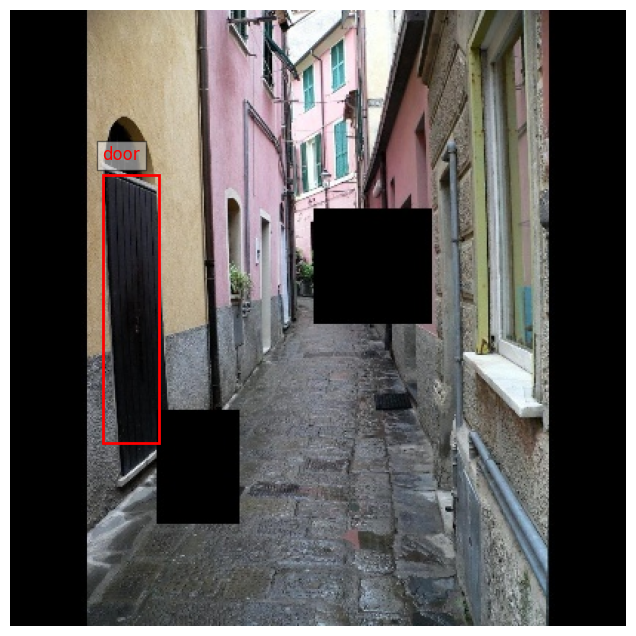

In [111]:
# Plot random images
def plot_image_with_bboxes(image_path, label_path, class_names):
    img = cv2.imread(str(image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    with open(label_path, 'r') as f:
        lines = f.readlines()
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    height, width, _ = img.shape
    for line in lines:
        parts = line.strip().split()
        if len(parts) < 5:
            continue
        class_id = int(float(parts[0]))
        x_center, y_center, bbox_width, bbox_height = map(float, parts[1:5])
        x_min = int((x_center - bbox_width / 2) * width)
        y_min = int((y_center - bbox_height / 2) * height)
        x_max = int((x_center + bbox_width / 2) * width)
        y_max = int((y_center + bbox_height / 2) * height)
        plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                          edgecolor='red', facecolor='none', linewidth=2))
        class_name = class_names.get(class_id, f"Class {class_id}")
        plt.text(x_min, y_min - 10, class_name, color='red', fontsize=12, 
                 bbox=dict(facecolor='white', alpha=0.5))
    plt.axis('off')
    plt.show()

augmented_image_files = list(augmented_images_dir.glob('*.jpg'))
random_images = random.sample(augmented_image_files, min(3, len(augmented_image_files)))
for image_path in random_images:
    label_path = augmented_labels_dir / (image_path.stem + '.txt')
    if label_path.exists():
        plot_image_with_bboxes(image_path, label_path, class_names)
    else:
        logger.warning(f"Label file not found for {image_path}")

## Visualizing Original vs. Augmented Images



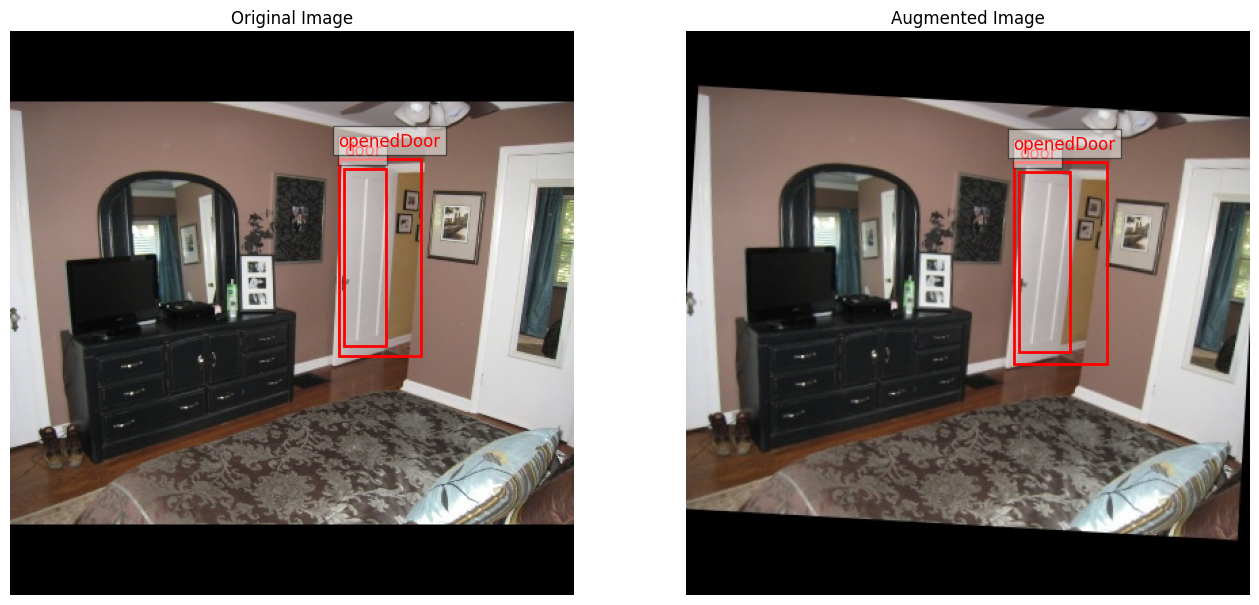

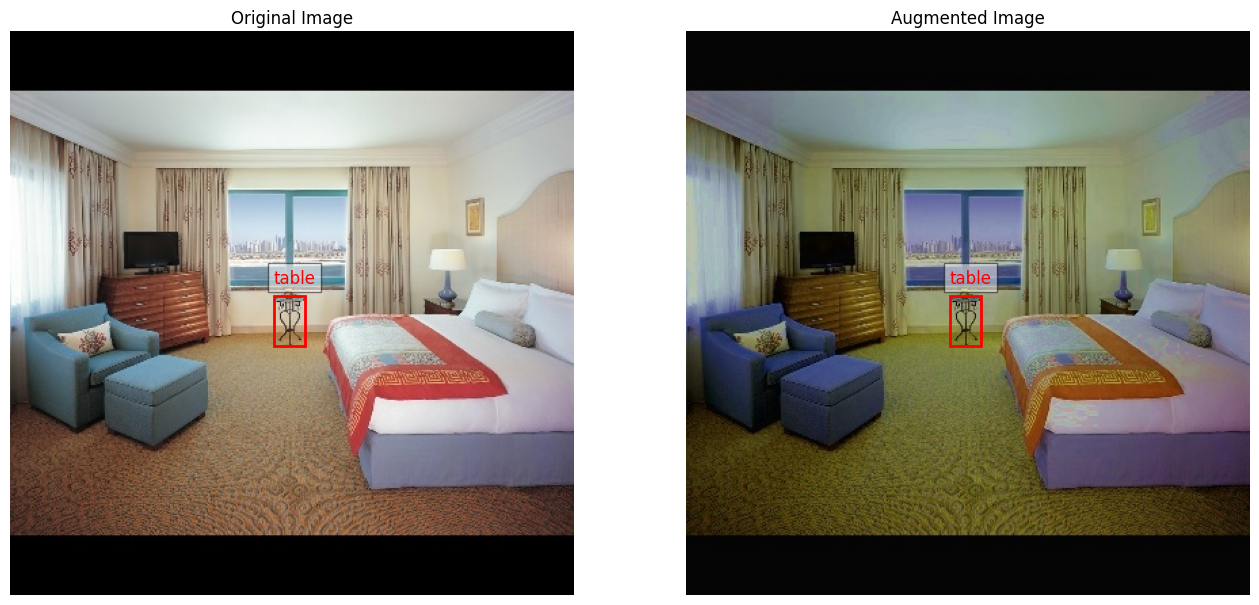

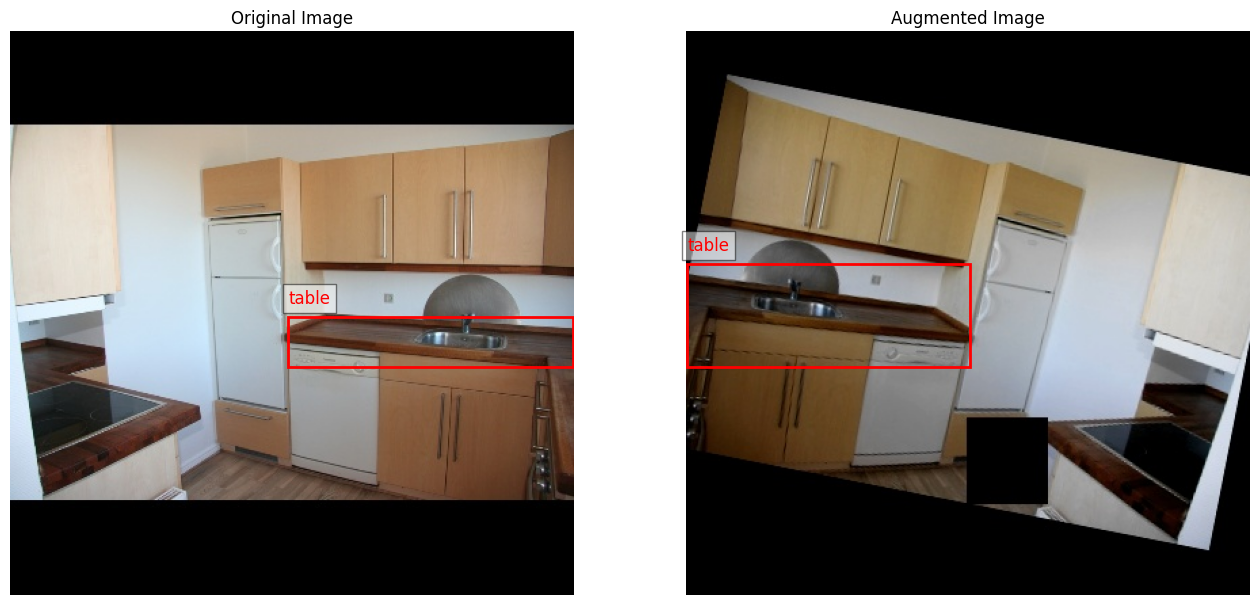

In [112]:
# Find augmented images with corresponding originals
augmented_images = [img for img in augmented_images_dir.glob("*_aug_*.jpg")]
random_images = random.sample(augmented_images, min(3, len(augmented_images)))  # Visualize 3 random pairs

for aug_image_path in random_images:
    # Extract original image stem (assuming format like "n_908_aug_1.jpg")
    original_stem = aug_image_path.stem.split("_aug_")[0]
    original_image_path = augmented_images_dir / f"{original_stem}.jpg"
    original_label_path = augmented_labels_dir / f"{original_stem}.txt"
    aug_label_path = augmented_labels_dir / f"{aug_image_path.stem}.txt"

    if not (original_image_path.exists() and original_label_path.exists() and aug_label_path.exists()):
        print(f"Skipping {aug_image_path}: Missing original or label files.")
        continue

    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Load and plot original image
    img_orig = cv2.imread(str(original_image_path))
    img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
    with open(original_label_path, "r") as f:
        orig_lines = f.readlines()
    axes[0].imshow(img_orig)
    h, w = img_orig.shape[:2]
    for line in orig_lines:
        parts = line.strip().split()
        if len(parts) < 5:
            continue
        class_id = int(float(parts[0]))
        x_center, y_center, bbox_w, bbox_h = map(float, parts[1:5])
        x_min = int((x_center - bbox_w / 2) * w)
        y_min = int((y_center - bbox_h / 2) * h)
        x_max = int((x_center + bbox_w / 2) * w)
        y_max = int((y_center + bbox_h / 2) * h)
        axes[0].add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                        edgecolor="red", facecolor="none", linewidth=2))
        class_name = class_names.get(class_id, f"Class {class_id}")
        axes[0].text(x_min, y_min - 10, class_name, color="red", fontsize=12,
                     bbox=dict(facecolor="white", alpha=0.5))
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Load and plot augmented image
    img_aug = cv2.imread(str(aug_image_path))
    img_aug = cv2.cvtColor(img_aug, cv2.COLOR_BGR2RGB)
    with open(aug_label_path, "r") as f:
        aug_lines = f.readlines()
    axes[1].imshow(img_aug)
    h, w = img_aug.shape[:2]
    for line in aug_lines:
        parts = line.strip().split()
        if len(parts) < 5:
            continue
        class_id = int(float(parts[0]))
        x_center, y_center, bbox_w, bbox_h = map(float, parts[1:5])
        x_min = int((x_center - bbox_w / 2) * w)
        y_min = int((y_center - bbox_h / 2) * h)
        x_max = int((x_center + bbox_w / 2) * w)
        y_max = int((y_center + bbox_h / 2) * h)
        axes[1].add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                        edgecolor="red", facecolor="none", linewidth=2))
        class_name = class_names.get(class_id, f"Class {class_id}")
        axes[1].text(x_min, y_min - 10, class_name, color="red", fontsize=12,
                     bbox=dict(facecolor="white", alpha=0.5))
    axes[1].set_title("Augmented Image")
    axes[1].axis("off")

    plt.show()

### Original vs Augmented Dataset

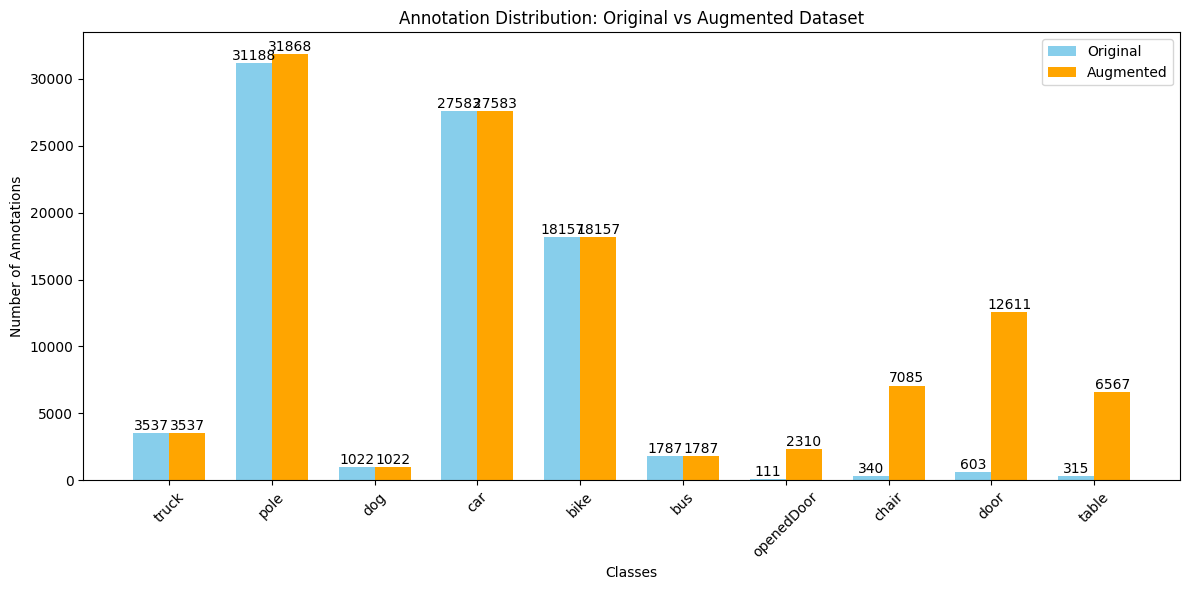

In [114]:
# Class names 
class_names = ['truck', 'pole', 'dog', 'car', 'bike', 'bus', 'openedDoor', 'chair', 'door', 'table']

# Original annotation counts 
original_counts = [3537, 31188, 1022, 27583, 18157, 1787, 111, 340, 603, 315]

# Augmented annotation counts 
augmented_counts = [3537, 31868, 1022, 27583, 18157, 1787, 2310, 7085, 12611, 6567]

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Define bar width and positions
bar_width = 0.35
index = np.arange(len(class_names))

# Create bars for original and augmented datasets
bars1 = ax.bar(index, original_counts, bar_width, label='Original', color='skyblue')
bars2 = ax.bar(index + bar_width, augmented_counts, bar_width, label='Augmented', color='orange')

# Add labels and title
ax.set_xlabel('Classes')
ax.set_ylabel('Number of Annotations')
ax.set_title('Annotation Distribution: Original vs Augmented Dataset')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(class_names, rotation=45)
ax.legend()

# Function to add value labels above bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f'{height}', 
                ha='center', va='bottom')

# Add value labels to both sets of bars
add_value_labels(bars1)
add_value_labels(bars2)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()